In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import scienceplots
import random

from utils import combine_meta_test

## Score vs. Design Number

In [2]:
Tag_tests = pd.read_pickle('Taguchi_test_dict.pkl') # All 32 Taguchi tests
Tag_meta = pd.read_csv('Tag_d_params.csv') # Meta data for Taguchi tests
Tag_df = combine_meta_test(Tag_meta, Tag_tests)
Tag_df = Tag_df.dropna(subset=['max_current']) # Remove any incomplete tests

In [3]:
# recreate initialization
seed = 116
Number_of_initialization_trials = 10
random.seed(seed)
choices = random.sample(range(0, 32), Number_of_initialization_trials)

In [4]:
# load meta and test data for BO designs
BO_meta_file = 'BO_designs/BO_d_params.csv' #.csv
OS_meta_file = 'BO_designs/BO_OneShot_meta_vals.csv' #.csv
BO_test_file = 'BayzOp_test_dict.pkl' #.pkl

BO_d_params = pd.read_csv(BO_meta_file) # all BO designs
OS_d_params = pd.read_csv(OS_meta_file) # all BO designs
BO_tests = pd.read_pickle(BO_test_file)
BO_df = combine_meta_test(BO_d_params, BO_tests) # combine meta and test data
OS_df = combine_meta_test(OS_d_params, BO_tests) # combine meta and test data

In [5]:
# add a 'Score' to Tag_df
for i, row in Tag_df.iterrows():
    if row['max_dxt'] >= 0.95:
        max_dxt = 1e12
    else:
        max_dxt = row['max_dxt']
    Tag_df.at[i, 'Score'] = row['gear_ratio'] / max_dxt

# add a 'Score' to BO_df
for i, row in BO_df.iterrows():
    if row['max_dxt'] >= 0.95:
        max_dxt = 1e12
    else:
        max_dxt = row['max_dxt']
    BO_df.at[i, 'Score'] = row['gear_ratio'] / max_dxt

# add a 'Score' to OS_df
for i, row in OS_df.iterrows():
    if row['max_dxt'] >= 0.95:
        max_dxt = 1e12
    else:
        max_dxt = row['max_dxt']
    OS_df.at[i, 'Score'] = row['gear_ratio'] / max_dxt

In [6]:
init_df = Tag_df.iloc[choices]
# arrange by design number
init_df = init_df.sort_values(by='Design')

In [7]:
init_df['Design'] = range(0, len(init_df))

In [8]:
# combine init and BO data, init then BO:
combined_df = pd.concat([init_df, BO_df], ignore_index=True)


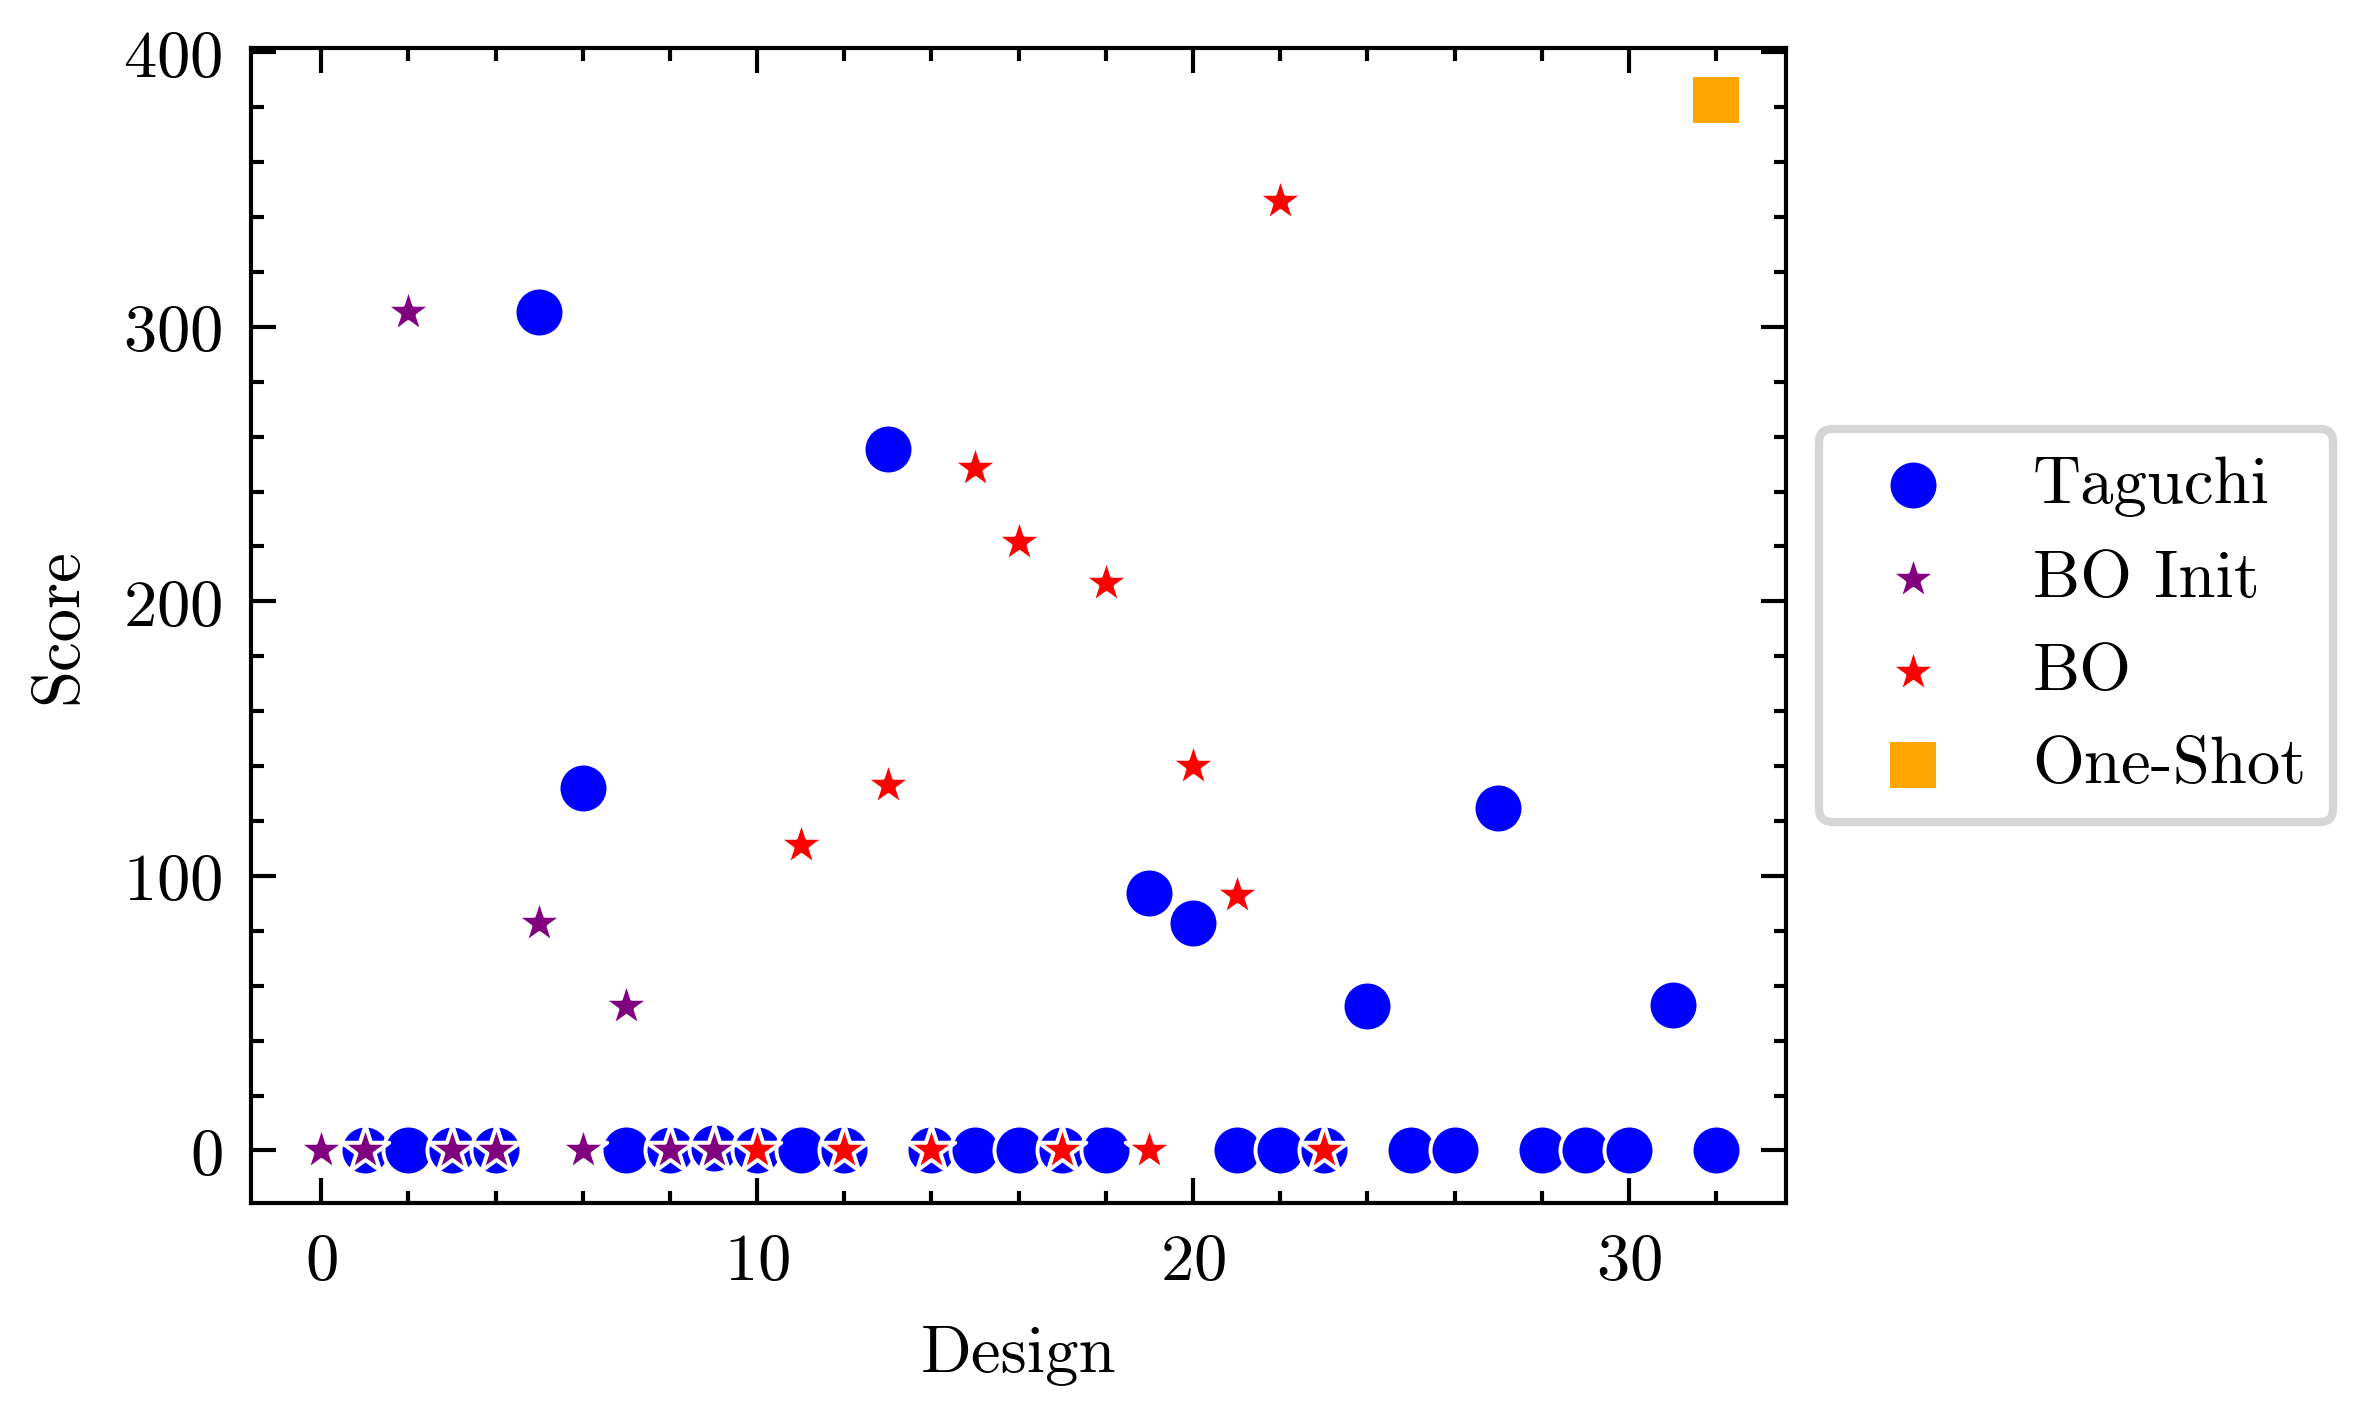

In [9]:
# plot the scores by the test numbers for the two methods on the same plot
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.scatterplot(data=Tag_df, x='Design', y='Score', color='b', marker='o', label='Taguchi')
    sns.scatterplot(data=init_df, x='Design', y='Score', color='purple', marker='*', label='BO Init')
    sns.scatterplot(data=BO_df, x='Design', y='Score', color='r', marker = '*', label = 'BO')
    sns.scatterplot(data=OS_df, x='Design', y='Score', color='orange', marker = 's', label = 'One-Shot')
    # show legend with a border outside of the plot
    # plt.legend(loc='upper left', frameon=True, borderpad=1, borderaxespad=1)
    ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5), frameon=True)
    plt.show()

## Score vs. Model Accuracy & Uncertainty

In [10]:
all_BO_acc = pickle.load(open('all_BO_acc_0.0.pkl','rb'))
all_tag_error = pickle.load(open('all_tag_error_0.0.pkl','rb'))
all_BO_SEM = pickle.load(open('all_BO_SEM_0.0.pkl','rb'))
all_tag_SEM = pickle.load(open('all_tag_SEM_0.0.pkl','rb'))

In [44]:
avg_BO_SEM = []
avg_BO_error = []
for ind in range(len(all_BO_SEM)):
    bo_sems = [x['Max_torque_gear_ratio_product'][1] for x in all_BO_SEM[ind]]
    bo_errors = all_BO_acc[ind][0]
    avg_BO_SEM.append(np.mean(bo_sems))
    avg_BO_error.append(np.mean(bo_errors))

BO_scores = np.array(BO_df['Score'][np.isfinite(BO_df['Score'])])

In [55]:
# adjust for acquiring 2 at a time
new_avg_BO_SEM = []
new_avg_BO_error = []
for i in range(len(avg_BO_SEM)):
    if i % 2 == 0:  # For even indices
        new_avg_BO_SEM.append(avg_BO_SEM[i])
        new_avg_BO_error.append(avg_BO_error[i])
    else:  # For odd indices
        new_avg_BO_SEM.append(avg_BO_SEM[i-1])  # Use previous even value
        new_avg_BO_error.append(avg_BO_error[i-1])

# normalize
new_avg_BO_SEM = new_avg_BO_SEM / np.max(new_avg_BO_SEM)
new_avg_BO_error = new_avg_BO_error / np.max(new_avg_BO_error)

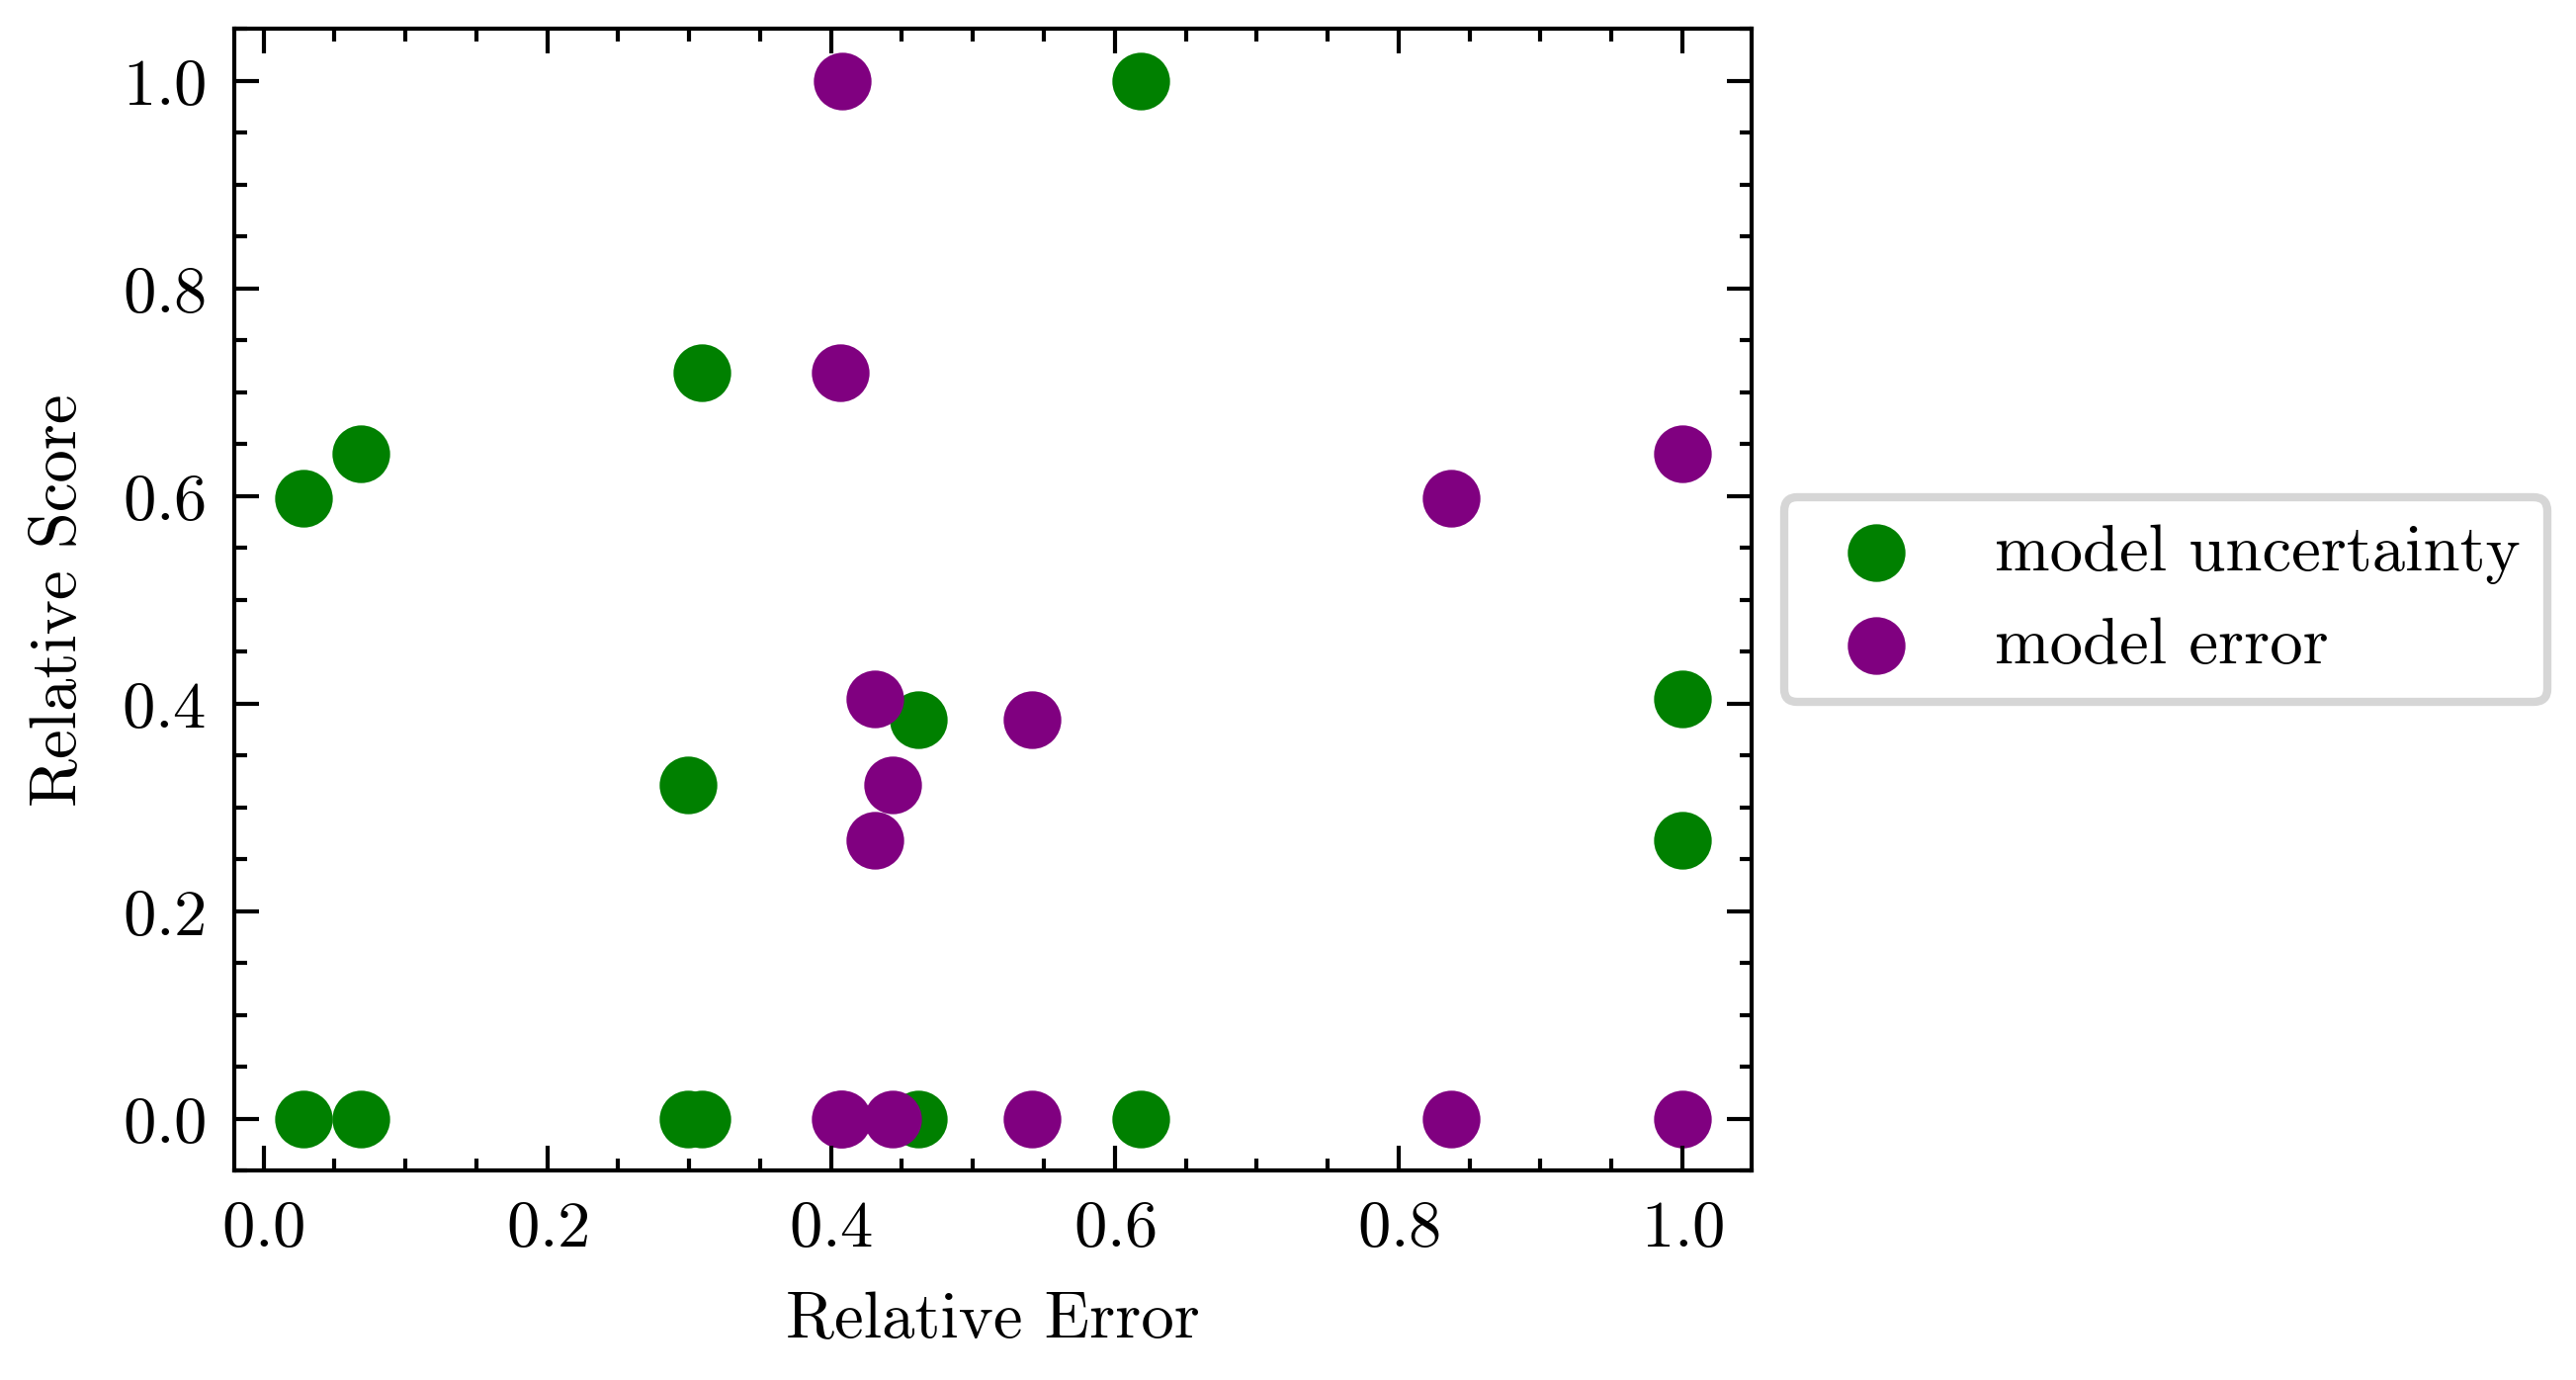

In [61]:
# plot the scores by the errors and accuracies (2 plots)
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # ax.scatter(avg_BO_SEM/np.max(avg_BO_SEM), BO_scores/np.max(BO_scores), color = 'b', label= 'model uncertainty')
    # ax.scatter(avg_BO_error/np.max(avg_BO_error), BO_scores/np.max(BO_scores), color = 'r', label = 'model error')
    ax.scatter(new_avg_BO_SEM, BO_scores/np.max(BO_scores), color = 'g', label= 'model uncertainty')
    ax.scatter(new_avg_BO_error, BO_scores/np.max(BO_scores), color = 'purple', label = 'model error')
    
    ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5), frameon=True)
    ax.set_xlabel('Relative Error')
    ax.set_ylabel('Relative Score')
    plt.show()

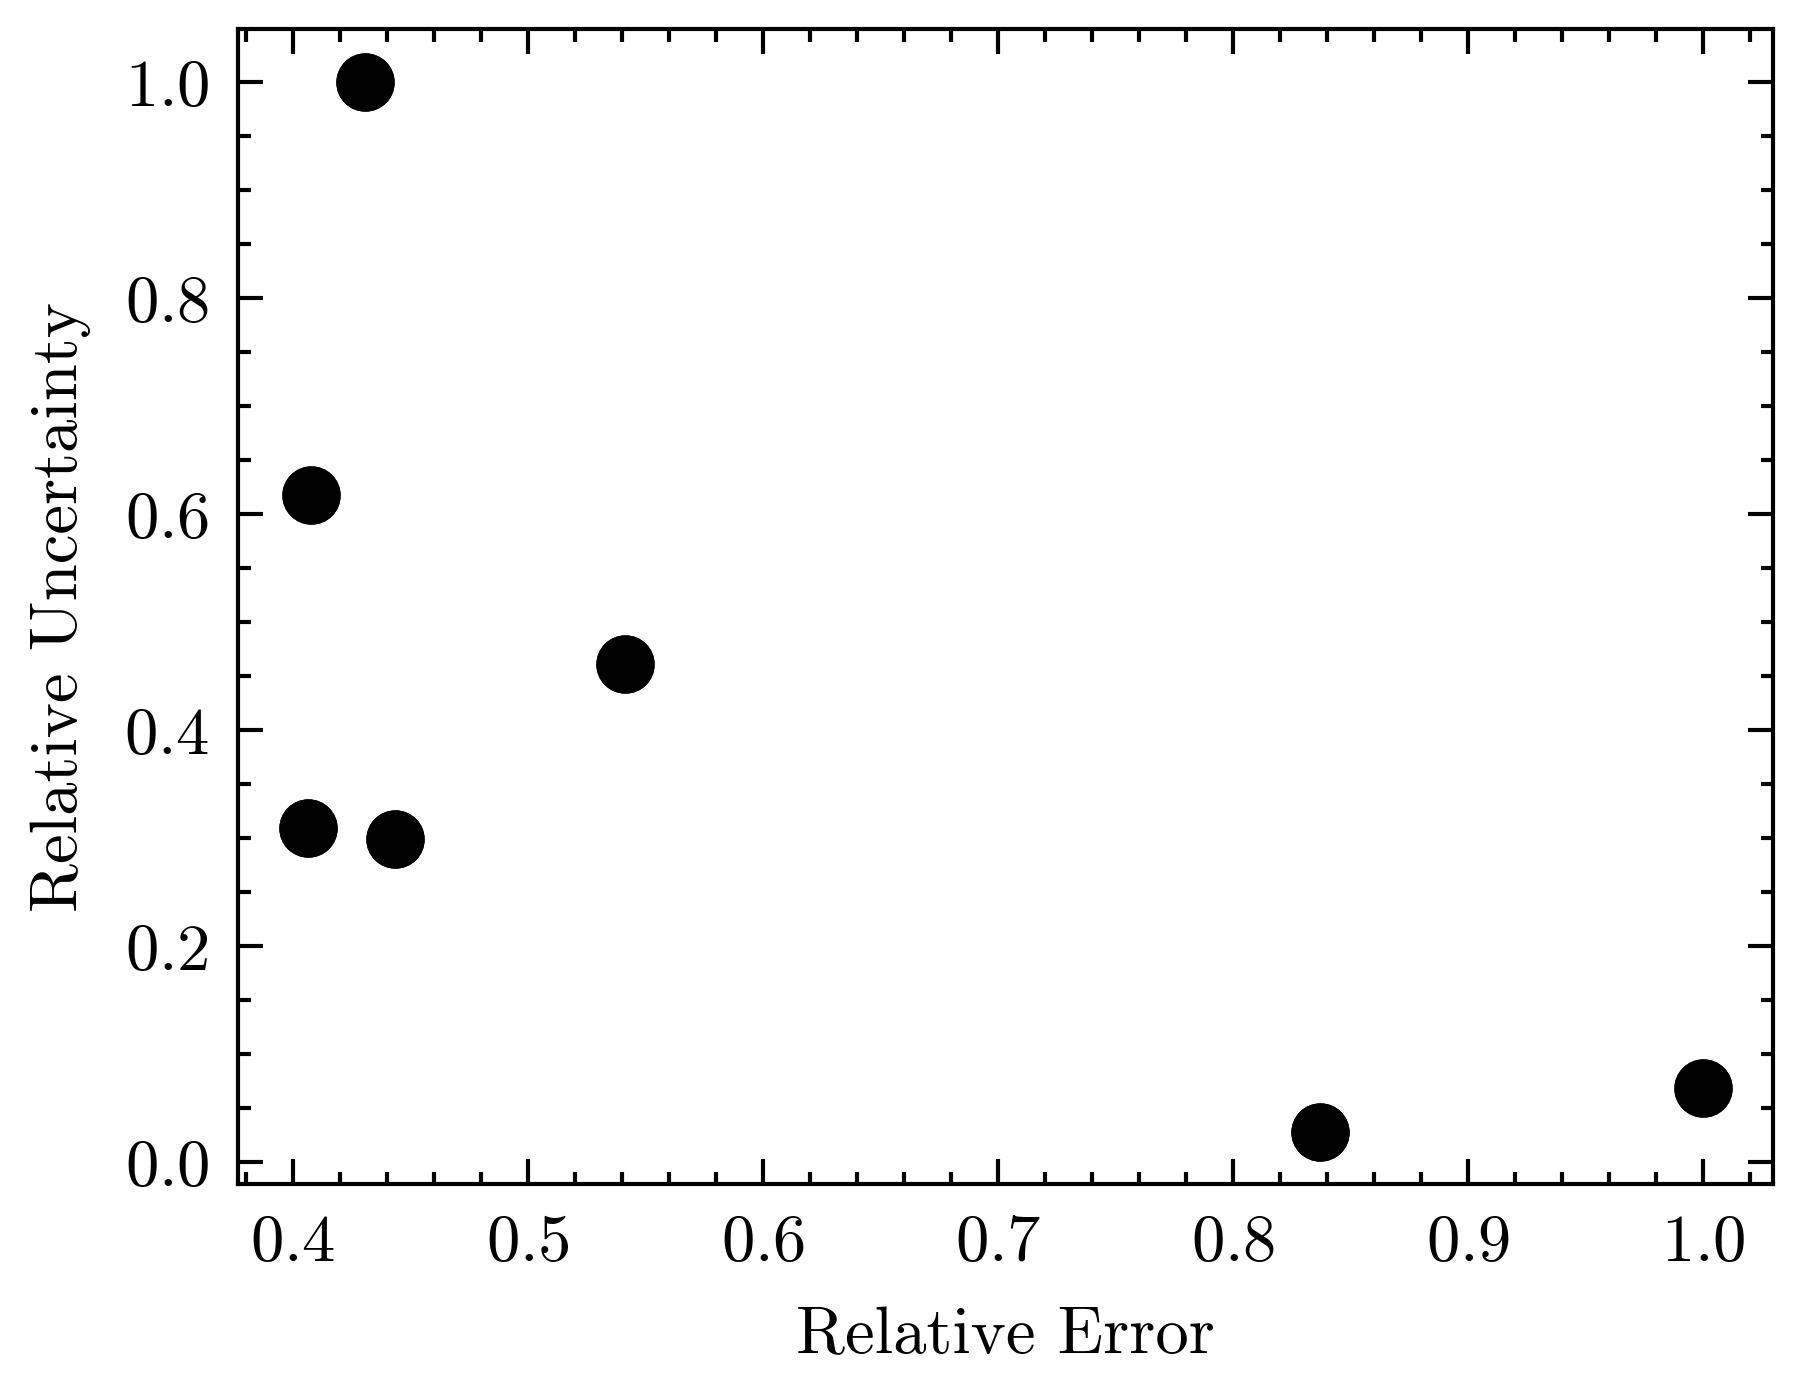

In [57]:
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # ax.scatter(avg_BO_SEM/np.max(avg_BO_SEM), BO_scores/np.max(BO_scores), color = 'b', label= 'model uncertainty')
    # ax.scatter(avg_BO_error/np.max(avg_BO_error), BO_scores/np.max(BO_scores), color = 'r', label = 'model error')
    ax.scatter(new_avg_BO_error,new_avg_BO_SEM)
    ax.set_xlabel('Relative Error')
    ax.set_ylabel('Relative Uncertainty')
    plt.show()

In [18]:
print(len(all_BO_SEM), len(avg_BO_SEM))

14 14


In [13]:
avg_BO_SEM

[938.1221207212199,
 167.6737302428381,
 1447.235715260036,
 2111.7462780829374,
 968.9609165499903,
 6.4213031243155525,
 214.88675866970235,
 586.3109470088232,
 88.28217609216426,
 148.37146738277278,
 3135.5916219181818,
 1926.1125692038909,
 1937.5023924119487,
 2297.9551799284795]

In [29]:
data=BO_df

array([1.04732394e-10, 1.11214354e+02, 7.11694915e-11, 1.33059831e+02,
       5.38801843e-11, 2.48446138e+02, 2.21685461e+02, 1.12228814e-10,
       2.06798596e+02, 1.18326733e-10, 1.39887812e+02, 9.29652810e+01,
       3.45796182e+02, 1.18326733e-10])

In [31]:
data.iloc[0]

Design                   10
material                ABS
lubricant                LI
z_sh                      7
z_r2                     77
x_s               -0.357144
x_r2               0.760397
Cl                   0.0003
g_thickness_h             6
p1_offset                 2
p2_offset                 2
gear_ratio       104.732394
max_current        1087.875
max_dxt            0.964809
Score                   0.0
Name: 0, dtype: object